In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import sys
import numpy.linalg as la
from tabulate import tabulate
import random
%matplotlib inline
from PIL import Image

# 1.c

In [2]:
# Load data
data = np.load("blurring.npz")
X = data['X']
y = data['y']

U, S, Vt = np.linalg.svd(X, full_matrices=False)

# Estimate w using X and y with regular least squares
# Your code here
w_LS = Vt.T @ np.diag(1 / S) @ U.T @ y

# Estimate w using X and y with truncated SVD
# Your code here
w_15 = (Vt[:15, :]).T @ np.diag(1 / S[:15]) @ (U[:, :15]).T @ y
w_75 = (Vt[:75, :]).T @ np.diag(1 / S[:75]) @ (U[:, :75]).T @ y
w_200 = (Vt[:200, :]).T @ np.diag(1 / S[:200]) @ (U[:, :200]).T @ y

# 1.c.i

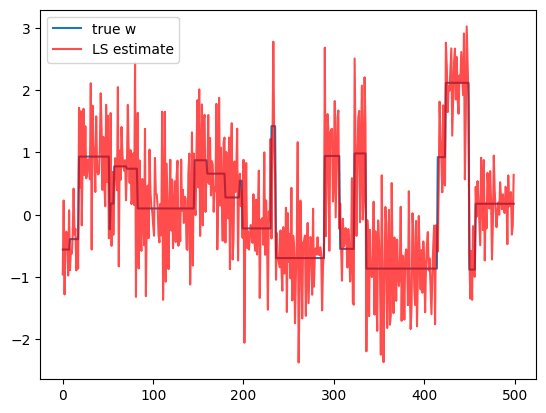

In [3]:
# Compare estimate to true value for LS
plt.plot(data['w'],label='true w')
plt.plot(w_LS, alpha=0.7,c='red',label='LS estimate')
plt.legend()
plt.show()

The standard least squares does not account for noise in a dataset, so we see the LS estimate deviating from the true weight in order to incorporate the noisy data.

# 1.c.ii

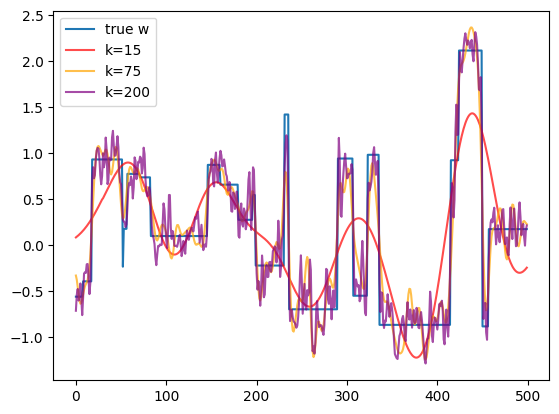

In [4]:
plt.plot(data['w'],label='true w')
plt.plot(w_15, alpha=0.7,c='red',label='k=15')
plt.plot(w_75, alpha=0.7,c='orange',label='k=75')
plt.plot(w_200, alpha=0.7,c='purple',label='k=200')
plt.legend()
plt.show()

We use the truncated SVD in order to produce a weight vector based on the $k$ most important singular values. By ignoring potentially very small singular values that may arise from added noise, the truncated SVD performs better than the regular LS since it can ignore noise more effectively. Since a lower $k$ indicates a loss of information from the dataset when $k < rank(X)$, we see smoother curves for higher $k$ values. However, it is important to consider balancing a smoother approximation and losing too much information with lower $k$ values.

# 2b

In [5]:
n = 4
trials = 1000

In [6]:
A = np.array([[0, 0, 0, 1], [1, 0, 0, 0], [0, 0.5, 0, 0], [0, 0.5, 1, 0]])
pi = np.array(np.random.rand(n)).reshape((n, 1))
normalized_pi = pi / np.sum(pi)

for i in range(trials):
    pi = A @ normalized_pi
    normalized_pi = pi / np.sum(pi)
normalized_pi

array([[0.28571429],
       [0.28571429],
       [0.14285714],
       [0.28571429]])

Thus, $\pi_1 = \pi_2 = \pi_4 = 0.2857$ and $\pi_3 = 0.1429$.

# 2c

In [7]:
alpha = 0.8

G = alpha * A + (1 - alpha) / n * np.ones(n).T @ np.ones(n)
G = G / G.sum(axis=0)
pi = np.array(np.random.rand(n)).reshape((n, 1))
normalized_pi = pi / np.sum(pi)

for i in range(trials):
    pi = G @ normalized_pi
    normalized_pi = pi / np.sum(pi)
normalized_pi

array([[0.26724138],
       [0.25862069],
       [0.18965517],
       [0.28448276]])

Thus, $\pi_1 = 0.2672$, $\pi_2 = 0.2586$, $\pi_3 = 0.1897$, and $\pi_4 = 0.2845$.

# 3a

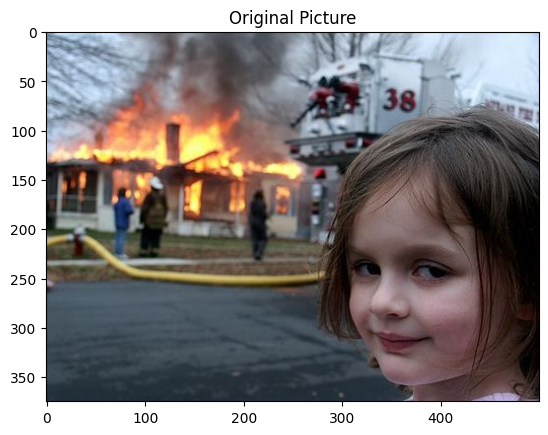

In [8]:
# feel free to use your favorite picture
# or work with the provided one
img = Image.open("disaster-girl.jpg", mode="r")
img = np.array(img).astype(np.int32)

plt.imshow(img)
plt.title('Original Picture')
plt.show()

# YOUR CODE BELOW
# note that images usually have 3 channels
# so, you can reshape it
# img_stack = face.reshape((img.shape[0], -1)) 
# and find its SVD.
# another option is to find the SVD of every color channel

img_stack = img.reshape((img.shape[0], -1)) 
U, S, Vt = np.linalg.svd(img_stack, full_matrices=False)

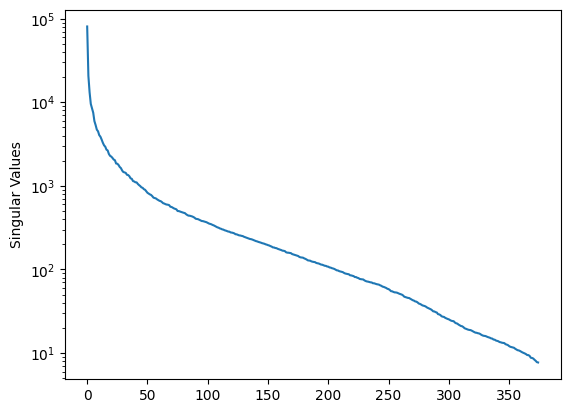

In [9]:
plt.plot(S)
plt.ylabel('Singular Values')
plt.yscale('log')
plt.show()

The singular values decrease as $\Sigma$ gives the singular matrices in non-increasing order.

# 3b

In [10]:
num_channels = 3

In [11]:
def compress(image, k):
    """
    Perform svd decomposition and truncate it (using k singular values/vectors)
    
    Parameters: 
        image (np.array): input image (probably, colourful)
        k (int): approximation rank (number of singular values)

    Returns:
      reconst_matrix (np.array): reconstructed matrix (tensor in colourful case)
      
      s (np.array): array of singular values 
    """
    # YOUR CODE IS HERE
    image = np.array(image).astype(np.int32)
    truncated = []
    s = []
    for channel in range(num_channels):
        current_img = image[:, :, channel]
        U, S, Vt = np.linalg.svd(current_img, full_matrices=False)
        new_channel = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
        truncated.append(new_channel)
        s.append(S[:k])
    reconst_matrix = np.stack(truncated, axis=-1)
    reconst_matrix = np.array(reconst_matrix).astype(np.int32)
    
    return reconst_matrix, np.array(s)

In [17]:
rank5_img, rank5_s = compress(img, 5)
rank20_img, rank20_s = compress(img, 20)
rank50_img, rank50_s = compress(img, 50)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(rank5_img)
ax[0].set_title('Rank 5')

ax[1].imshow(rank20_img)
ax[1].set_title('Rank 20')

ax[2].imshow(rank50_img)
ax[2].set_title('Rank 50')

plt.show()

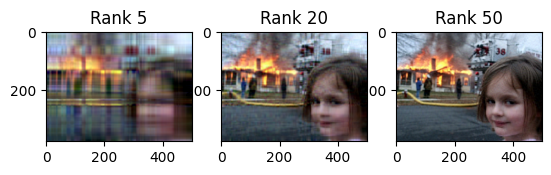

Is it clear that higher rank images more closely resemble the original image since we are losing less information with the truncation.

# 3c

In [13]:
def calculate_error(actual, expected):    
    return np.linalg.norm(expected - actual, 'fro') / np.linalg.norm(expected, 'fro')

In [21]:
max_k = min(img.shape[0], img.shape[1])
original_pred = compress(img, max_k)[0]
original_size = img.shape[0] * img.shape[1]

all_errors = []
all_sizes = []
for current_k in range(max_k):
    current_pred = compress(img, current_k)[0]
    total_error = 0
    total_size = img.shape[0] * current_k + img.shape[1] * current_k + current_k
    
    total_error = calculate_error(current_pred[:, :, 0], original_pred[:, :, 0])
    all_errors.append(total_error)
    all_sizes.append(total_size / original_size)

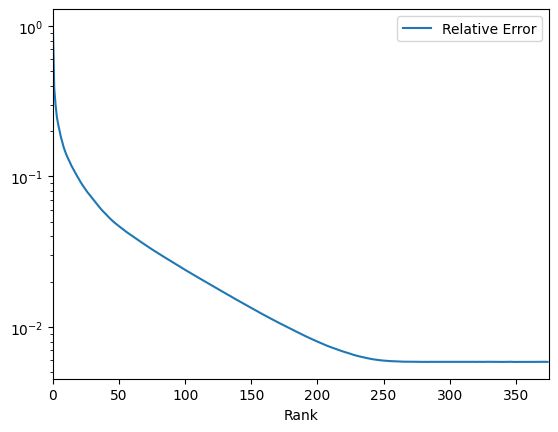

In [22]:
plt.plot(all_errors, label='Relative Error')
plt.xlabel('Rank')
plt.xlim((0, max_k))
plt.yscale('log')
plt.legend()
plt.show()

As rank increases, the relative error decreases. This makes sense because a higher rank means we are preserving more of the original image, so the discrepancy between the truncated and original decreases.

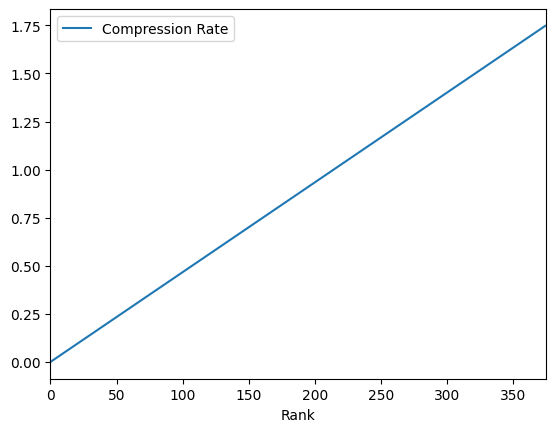

In [23]:
plt.plot(all_sizes, label='Compression Rate')
plt.xlabel('Rank')
plt.xlim((0, max_k))
plt.legend()
plt.show()

As rank increases, the compression rate increases. This makes sense because a higher rank means it takes more storage to preserve a greater amount of information. There are a variety of cutoffs we can use, but around $k=75$ we see a slight decrease in slope of the relative error, so it may be a good cutoff. Also, the compression rate is above $0.25$ when $k=75$, which may be sufficient. We can further verify this by a holistic approach since doing the $k=50$ approximation before yielded a relatively clear picture, so something around $k=75$ allows us to now have to store much information by using a small rank but also lets us have a relatively accurate image.